# AON_ACTION First Level Model

Master Thesis: **Modulation of the Action Observation Network - Investigating Action, Actor and Observer Factors in an fMRI Study**

Author: Olaf Borghi olafborghi@gmail.com

## Prepare Setup

### Define fixed parameters, load libraries/modules

In [401]:
# Import necessary packages and modules
%matplotlib inline
# libraries
import os
import numpy as np
import nibabel as nib
import pandas as pd
import nilearn as nl
from matplotlib import pyplot as plt
# specific modules
from nipype import Node, Workflow
from nipype.interfaces import fsl
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting, datasets, image
from pathlib import Path
from pprint import pprint
from glob import glob

In [402]:
# fixed folders
basedir = Path("/home/olafb99/mnt/p/userdata/olafb99/shared/03_AON_ACTION")
outputdir = Path(basedir / "derivatives")
datadir = Path(basedir / "01_data")

# first level output dir
if not os.path.exists(outputdir / "first_level"):
    os.makedirs(outputdir / "first_level")
first_level_dir = outputdir / "first_level"

### Load the warped anatomical and the preprocessed functional images

In [403]:
# create a function to load the MRI images with NiBabel (nib) for each sbj in a dict
def MyMRIImages(paths):
    ''' 
    Returns a dictionary with the functional or anatomical MRI images of each subject
    loaded as a nib.img
    Inputs: A list of paths to the functional/anatomical images, ordered by subject number
    '''
    images_dict = {}
    for i, p in enumerate(paths):
        img = nib.load(p)
        if i < 10: 
            images_dict[f"sub-0{i+1}"] = img
        elif i >= 10:
            images_dict[f"sub-{i+1}"] = img
    return images_dict

In [404]:
# store the paths of the warped anatomical images of all subjects in a list and load them using the function
anat_paths = sorted(glob(f"{outputdir}/*/AON_run-01.feat/reg/highres2standard.nii.gz"))
anat_dict = MyMRIImages(anat_paths)

# store the paths of the preprocessed functional image files of all subjects of AON_run-01 in a list and load them using the function
AON_run_01_paths = sorted(glob(f"{outputdir}/*/AON_run-01.feat/filtered_func_data.nii.gz"))
AON_run_01_dict = MyMRIImages(AON_run_01_paths)

# store the paths of the preprocessed functional image files of all subjects of AON_run-02 in a list and load them using the function
AON_run_02_paths = sorted(glob(f"{outputdir}/*/AON_run-02.feat/filtered_func_data.nii.gz"))
AON_run_02_dict = MyMRIImages(AON_run_02_paths)

# store the paths of the preprocessed functional image files of all subjects of action in a list and load them using the function
action_paths = sorted(glob(f"{outputdir}/*/action.feat/filtered_func_data.nii.gz"))
action_dict = MyMRIImages(action_paths)

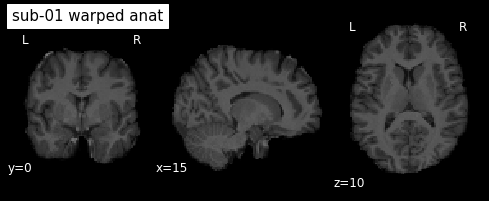

In [405]:
# sanity check - plot the warped anat a sbj
sbj = "sub-01"

plotting.plot_anat(anat_dict.get(sbj), title = f"{sbj} warped anat", 
                   draw_cross = False, black_bg = True, cut_coords = (15, 0, 10))

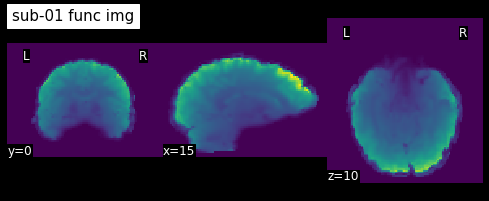

In [406]:
# sanity check - plot the preprocessed func file of a sbj
sbj = "sub-01"

func_img_mean = image.mean_img(AON_run_01_dict.get(sbj))
plotting.plot_img(func_img_mean, title = f"{sbj} func img", 
                   draw_cross = False, black_bg = True, cut_coords = (15, 0, 10))

### Load the realignment parameters and framewise displacement confounds

In [407]:
# create a function to load the motion parameters as pandas dataframes
def MyMotionParameters(par_paths, fd_paths):
    ''' 
    Returns a dictionary with the motion parameters and motion scrubbing of each subject for a task/run
    loaded as a pandas dataframe.
    Inputs: A list of paths to the motion parameters
    Output: dict with pandas dataframe of confounds for each subject
            and prints the percentage of volumes lost by framewise displacement > 0.9
    '''
    pars_dict = {}
    for j, f in enumerate(fd_paths):
        fd=np.loadtxt(f) 
        #fd = np.insert(fd, 0, 0, axis=0) # add a zero for the first volume, as no fd is calculated for it (
        fd = pd.DataFrame(fd)
        fd.columns=["FD"]
        fd = (fd >= 0.9)*1 # replace values < 0.9 with 0, and those > 0.9 with 1
        print("Percentage of volums with fd > 0.9 = ", np.sum(fd)*100/len(fd))
    
    for i, p in enumerate(par_paths):
        # load the motion parameters as txt
        par = np.loadtxt(p)
        # create a pd.DataFrame with column names of the motion parameters
        par = pd.DataFrame(par)
        par.columns =['x', 'y', 'z', 'pitch', 'roll', 'yaw']
        
        par = pd.concat((par,fd), axis = 1)
        
        if i < 10: 
            pars_dict[f"sub-0{i+1}"] = par
        elif i >= 10:
            pars_dict[f"sub-{i+1}"] = par
    return pars_dict

In [408]:
##########################
# Motion pars #
##########################

# store paths of action realignment parameters in a list and use the function to load the motion parameters of action
action_pars_path = sorted(glob(f"{outputdir}/*/action.feat/mc/prefiltered_func_data_mcf.par"))
action_fd_path = sorted(glob(f"{outputdir}/*/action.feat/motion_assess/confound.txt"))
action_pars_dict = MyMotionParameters(action_pars_path, action_fd_path)

# store paths of AON_run-01 realignment parameters in a list and use the function to load the motion parameters of AON_run-01
AON_run_01_pars_path = sorted(glob(f"{outputdir}/*/AON_run-01.feat/mc/prefiltered_func_data_mcf.par"))
AON_run_01_fd_path = sorted(glob(f"{outputdir}/*/AON_run-01.feat/motion_assess/confound.txt"))
AON_run_01_pars_dict = MyMotionParameters(AON_run_01_pars_path, AON_run_01_fd_path)

# store paths of AON_run-02 realignment parameters in a list and use the function to load the motion parameters of AON_run-02
AON_run_02_pars_path = sorted(glob(f"{outputdir}/*/AON_run-02.feat/mc/prefiltered_func_data_mcf.par"))
AON_run_02_fd_path = sorted(glob(f"{outputdir}/*/AON_run-02.feat/motion_assess/confound.txt"))
AON_run_02_pars_dict = MyMotionParameters(AON_run_02_pars_path, AON_run_02_fd_path)

Percentage of volums with fd > 0.9 =  FD    0.0
dtype: float64
Percentage of volums with fd > 0.9 =  FD    0.0
dtype: float64
Percentage of volums with fd > 0.9 =  FD    0.0
dtype: float64


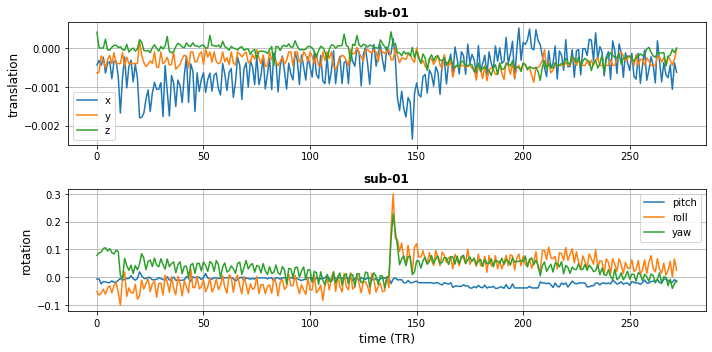

In [409]:
# sanity check - plot the motion parameters

for i in range(0,len(AON_run_01_pars_dict)):
    for sub, pars in AON_run_01_pars_dict.items():
        fig, axes = plt.subplots(nrows=2*len(AON_run_01_pars_dict), ncols=1, figsize=(10,5))
        axes[i].plot(pars[["x","y","z"]])
        axes[i+1].plot(pars[["pitch","roll","yaw"]])
        
        axes[i].set_ylabel("translation", fontsize = 12)
        axes[i+1].set_ylabel("rotation", fontsize = 12)
        axes[i+1].set_xlabel("time (TR)", fontsize = 12)

        axes[i].legend(["x","y","z"])
        axes[i+1].legend(["pitch","roll","yaw"])
  
        axes[i].set_title(sub, fontsize = 12, fontweight ='bold')
        axes[i+1].set_title(sub, fontsize = 12, fontweight ='bold')

        axes[i].grid()
        axes[i+1].grid()
        
        fig.tight_layout()

### Load the events.tsv files

In [410]:
# create a function to load the motion parameters as pandas dataframes
def MyEventFiles(paths):
    ''' 
    Returns a dictionary with the event files of each subject for a task/run
    loaded as a pandas dataframe.
    Inputs: A list of paths to the motion parameters
    '''
    events_dict = {}
    for i, p in enumerate(paths):
        # load events.tsv files
        events = pd.read_table(p)
        if i < 10: 
            events_dict[f"sub-0{i+1}"] = events
        elif i >= 10:
            events_dict[f"sub-{i+1}"] = events
    return events_dict

In [411]:
# load paths of AON_run-01 event files in a list and use the function to store them in a dict
AON_run_01_events_path = sorted(glob(f"{datadir}/*/func/*_task-AON_run-01_events.tsv"))
AON_run_01_events_dict = MyEventFiles(AON_run_01_events_path)

# load paths of AON_run-02 event files in a list and use the function to store them in a dict
AON_run_02_events_path = sorted(glob(f"{datadir}/*/func/*_task-AON_run-02_events.tsv"))
AON_run_02_events_dict = MyEventFiles(AON_run_02_events_path)

# load paths of action event files in a list and use the function to store them in a dict
action_events_path = sorted(glob(f"{datadir}/*/func/*_task-action_events.tsv"))
action_events_dict = MyEventFiles(action_events_path)

In [412]:
# sanity check - inspect events.tsv file of a subject of AON run 01
sbj = "sub-01"
events_aon_run_01 = AON_run_01_events_dict.get(sbj)
# display shape of events file
print(events_aon_run_01.shape)
# display 5 first and last values of each column
events_aon_run_01.head(5)

(18, 12)


,onset,duration,offset,condition,trial_type,participant_id,date,session,attempt,run,dur_fixation,task_duration
0,5.044104,14.957332,20.001436,8,Human Scrambled,sub-01,2020-09-24-13-05-19,1,1,1,5,324.932103
1,25.036297,12.431768,37.468065,1,Dog Goal-directed,sub-01,2020-09-24-13-05-19,1,1,1,3,324.932103
2,40.503415,12.715053,53.218468,5,Dog Ghost,sub-01,2020-09-24-13-05-19,1,1,1,4,324.932103
3,57.252661,12.649943,69.902604,3,Dog Miming,sub-01,2020-09-24-13-05-19,1,1,1,5,324.932103
4,74.934853,12.816701,87.751554,7,Dog Scrambled,sub-01,2020-09-24-13-05-19,1,1,1,6,324.932103


In [413]:
# sanity check - inspect events.tsv file of a subject of action
sbj = "sub-01"
events_action = action_events_dict.get(sbj)
# display shape of events file
print(events_action.shape)
# display 5 first and last values of each column
events_action.head(5)

(12, 12)


,onset,duration,offset,condition,trial_type,participant_id,date,session,attempt,dur_fixation,task_duration,pic_name
0,10.001267,10.001324,20.002590,1,Hand motion,sub-01,2020-09-24-13-22-04,1,1,10,260.409657,hand_600x600.png
1,30.028533,10.000255,40.028787,1,Hand motion,sub-01,2020-09-24-13-22-04,1,1,10,260.409657,hand_600x600.png
2,50.060787,10.001550,60.062337,2,Mouth motion,sub-01,2020-09-24-13-22-04,1,1,10,260.409657,mouth_600x600.png
3,70.094950,10.000961,80.095911,2,Mouth motion,sub-01,2020-09-24-13-22-04,1,1,10,260.409657,mouth_600x600.png
4,90.127574,10.000279,100.127853,1,Hand motion,sub-01,2020-09-24-13-22-04,1,1,10,260.409657,hand_600x600.png


Now everything should be set and ready to fit the first level model! :)

## First level model of one subject

In [414]:
# I used the TR from the experiment, and for all other params I used the default values
first_level = FirstLevelModel(t_r=1.2,
                              hrf_model="spm",
                              drift_model="cosine",
                              slice_time_ref=0, # slice time correction was already applied
                              high_pass=1/128, 
                              minimize_memory = False, # for voxelwise attributes like R-Squared
                              verbose=True) 

In [415]:
# fit AON first level model of sub-01
sbj = "sub-01"
first_level_fit = first_level.fit((AON_run_01_dict.get(sbj),AON_run_02_dict.get(sbj)), 
                                  events = (AON_run_01_events_dict.get(sbj),AON_run_02_events_dict.get(sbj)),
                                  confounds = (AON_run_01_pars_dict.get(sbj), AON_run_02_pars_dict.get(sbj)))

Computing run 1 out of 2 runs (go take a coffee, a big one)
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `dur_fixation` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `participant_id` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `condition` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `session` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/fir

(273, 21)
(271, 20)


Text(0.5, 1.0, 'AON run 02 design matrix')

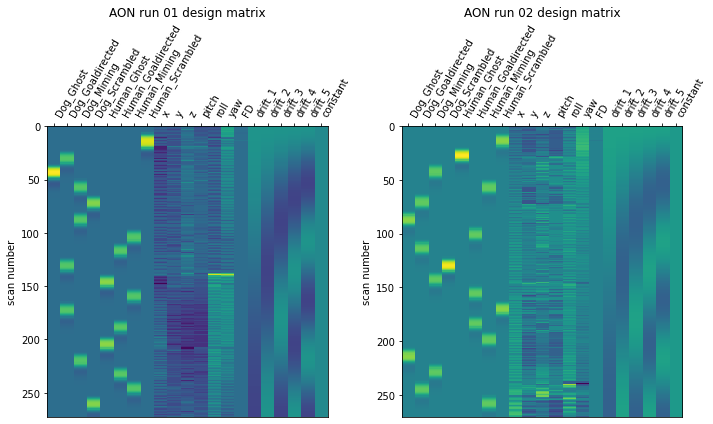

In [416]:
# we choose the first design matrix (model is implicitly ment for multiple run, we only analysed one run)
X1 = first_level_fit.design_matrices_[0]
X2 = first_level_fit.design_matrices_[1]
# print the shape of the design matrix
print(np.shape(design_matrix_run_01))
print(np.shape(design_matrix_run_02))

# plot the design matrix
from nilearn.plotting import plot_design_matrix
fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)
plot_design_matrix(X1, ax=ax1)
ax1.set_title('AON run 01 design matrix', fontsize=12)
plot_design_matrix(X2, ax=ax2)
ax2.set_title('AON run 02 design matrix', fontsize=12)

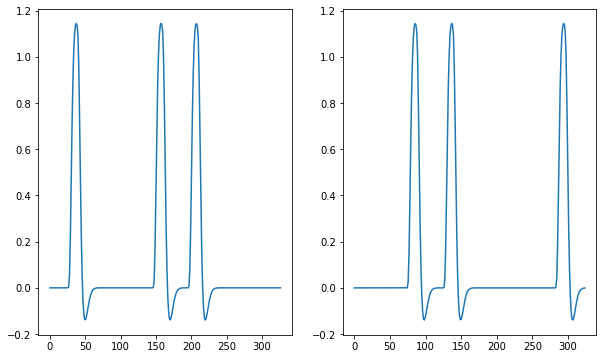

In [417]:
# plot an exemplary HRF
fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)
axes[0].plot(X1["Dog_Goaldirected"])
axes[1].plot(X2["Dog_Goaldirected"])

#### Looks good, let's calculate and plot some contrasts as safety checks

1. Main conditions > Baseline
2. Motion parameters > Baseline

In [418]:
n_columns = first_level_fit.design_matrices_[0].shape[1]

def pad_vector(contrast_, n_columns):
    """A small routine to append zeros in contrast vectors"""
    return np.hstack((contrast_, np.zeros(n_columns - len(contrast_))))

In [419]:
# setup contrast dictonary for run 01
contrasts = {
  "main-baseline": pad_vector([0, 1, 1, 0, 0, 1, 1,], n_columns),
  "motion-baseline": pad_vector([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], n_columns),
}

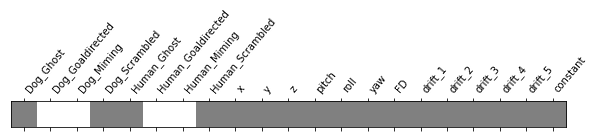

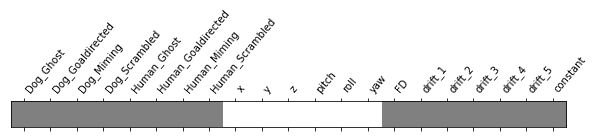

In [420]:
# plot the contrast matrix
for id, val in contrasts.items():
  plotting.plot_contrast_matrix(val, design_matrix=X1)

In [421]:
print('Computing contrasts...')
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('  Contrast % 2i out of %i: %s' % (
        index + 1, len(contrasts), contrast_id))
    # Estimate the contasts. Note that the model implicitly computes a fixed
    # effect across the two sessions
    z_map = first_level.compute_contrast(
        contrast_val, output_type='z_score')

    # write the resulting stat images to file
    z_image_path = f"{first_level_dir}/{contrast_id}_z_map.nii.gz"
    z_map.to_filename(z_image_path)

Computing contrasts...
  Contrast  1 out of 2: main-baseline


/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


  Contrast  2 out of 2: motion-baseline


### Compare the different results (AON_run-01 vs. AON_run-02 vs. across runs)

**Across AON Run 1 and AON Run 2**

contrast id: main-baseline
contrast val: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


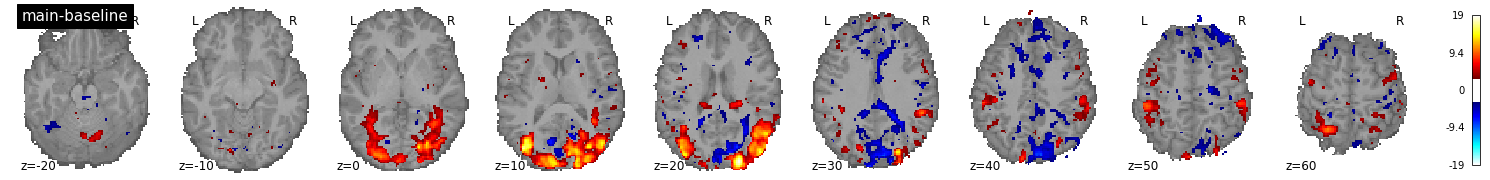

contrast id: motion-baseline
contrast val: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/first_level.py:696: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


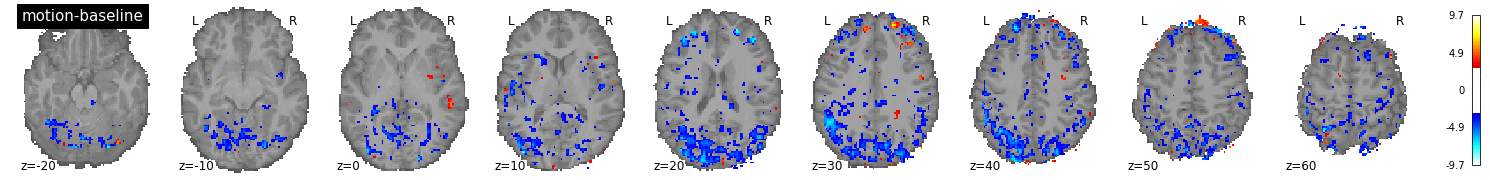

In [422]:
# plotting the contrast maps for each condition

for contrast_id, contrast_val in contrasts.items():
    print(f"contrast id: {contrast_id}")
    print(f"contrast val: {contrast_val}")
    
    # compute the contrasts
    z_map = first_level.compute_contrast(contrast_val, 
                                      output_type='z_score')
    # plot the contrasts 
    # the display is overlaid on the warped anatomical
    plotting.plot_stat_map(
        z_map, 
        bg_img=anat_dict.get(sbj), 
        threshold=3.0, 
        display_mode='z',
        cut_coords=range(-20, 70, 10), 
        black_bg=False, 
        title=contrast_id,
        symmetric_cbar=True)
    plotting.show()

**Only AON Run 1**

Computing run 1 out of 1 runs (go take a coffee, a big one)
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `dur_fixation` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `participant_id` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `condition` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `session` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/fir

contrast id: main-baseline
contrast val: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


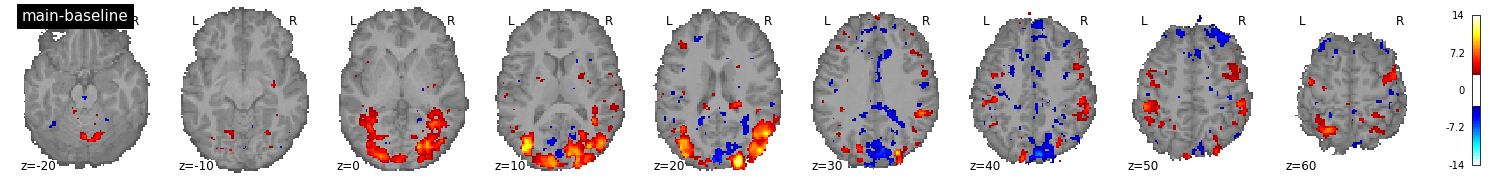

contrast id: motion-baseline
contrast val: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


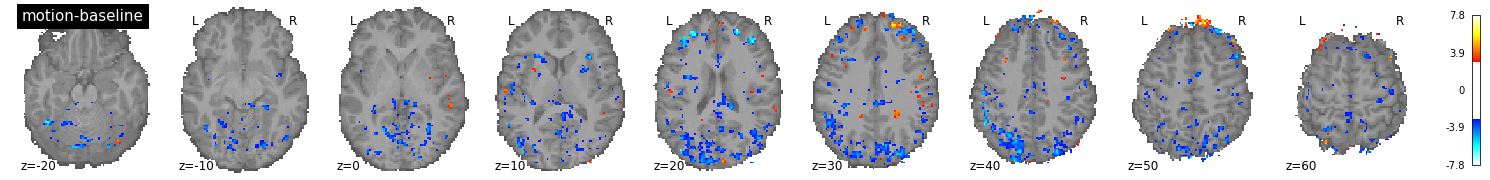

In [400]:
# fit AON Run 01 first level model of sub-01
sbj = "sub-01"
first_level = first_level.fit(AON_run_01_dict.get(sbj),
                              events = AON_run_01_events_dict.get(sbj),
                              confounds = AON_run_01_pars_dict.get(sbj))

for contrast_id, contrast_val in contrasts.items():
    print(f"contrast id: {contrast_id}")
    print(f"contrast val: {contrast_val}")
    
    # compute the contrasts
    z_map = first_level.compute_contrast(contrast_val, 
                                      output_type='z_score')
    # plot the contrasts 
    # the display is overlaid on the warped anatomical
    plotting.plot_stat_map(
        z_map, 
        bg_img=anat_dict.get(sbj), 
        threshold=3.0, 
        display_mode='z',
        cut_coords=range(-20, 70, 10), 
        black_bg=False, 
        title=contrast_id,
        symmetric_cbar=True)
    plotting.show()

**Only AON Run 2**

Computing run 1 out of 1 runs (go take a coffee, a big one)
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `dur_fixation` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `participant_id` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `condition` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `session` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/usr/local/lib/python3.8/dist-packages/nilearn/glm/fir

contrast id: main-baseline
contrast val: [0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


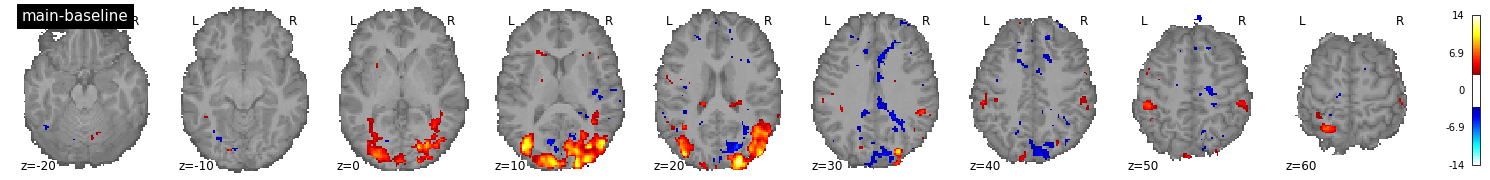

contrast id: motion-baseline
contrast val: [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]


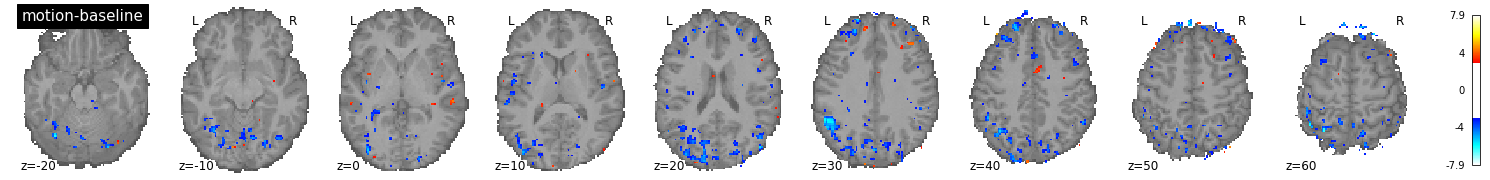

In [324]:
# fit AON Run 01 first level model of sub-01
sbj = "sub-01"
first_level = first_level.fit(AON_run_02_dict.get(sbj),
                              events = AON_run_02_events_dict.get(sbj),
                              confounds = AON_run_02_pars_dict.get(sbj))

for contrast_id, contrast_val in contrasts.items():
    print(f"contrast id: {contrast_id}")
    print(f"contrast val: {contrast_val}")
    
    # compute the contrasts
    z_map = first_level.compute_contrast(contrast_val, 
                                      output_type='z_score')
    # plot the contrasts 
    # the display is overlaid on the warped anatomical
    plotting.plot_stat_map(
        z_map, 
        bg_img=anat_dict.get(sbj), 
        threshold=3.0, 
        display_mode='z',
        cut_coords=range(-20, 70, 10), 
        black_bg=False, 
        title=contrast_id,
        symmetric_cbar=True)
    plotting.show()

**Trying the save GLM to BIDS function**

In [ ]:
# save_glm_to_bids()

## First takeaway

The first level model works, and aggregating across the two runs improves the signal to noise ratio.

So now its time to create a function to compute the first_level model for all 40 subjects for the AON task.

Helpful resources:

https://lukas-snoek.com/NI-edu/fMRI-introduction/week_7/nilearn_stats.html#creating-design-matrices

**In this link there is also a function to do the first level model for multiple subjects, I will adapt it next!**

In [ ]:
# not yet adapted!!!
# next up: implement first level model for all subjects :)

import os
import numpy as np
import pandas as pd
import nibabel as nib
from glob import glob
from tqdm.notebook import tqdm
from nilearn import masking
from nilearn.glm.first_level import FirstLevelModel

def fit_firstlevel(sub, bids_dir, task='MGT', run='01', space='MNI152NLin2009cAsym', 
                   conf_cols=None, **flm_kwargs):
    """ Example function of how you could implement a complete
    first-level analysis for a single subject. Note that this is
    just one way of implementing this; there may be (much more efficient)
    ways to do this.
    
    Parameters
    ----------
    sub : str
        Subject-identifier (e.g., 'sub-01')
    bids_dir : str
        Path to BIDS directory (root directory)
    task : str
        Name of task to analyse
    run : str
        Name of run to analyze
    space : str
        Name of space of the data
    conf_cols : list (or None)
        List of confound names to include; if None, only 6 motion params
        are included
    **flm_kwargs : kwargs
        Keyword arguments for the FirstLevelModel constructor
    
    Returns
    -------
    flm : FirstLevelModel
        Fitted FirstLevelModel object
    """
    
    # If conf_cols is not set, let's use a "standard" set of
    # motion parameters (translation and rotation in 3 dimensions)
    if conf_cols is None:
        # Note: in new versions of Fmriprep, these variables are named differently,
        # i.e., trans_x, trans_y, trans_z, rot_x, rot_y, rot_z
        conf_cols = ['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']

    # We assume it's a BIDS formatted dataset with the Fmriprep outputs in
    # bids_dir/derivatives/fmriprep
    bids_func_dir = os.path.join(bids_dir, sub, 'func')
    fprep_func_dir = os.path.join(bids_dir, 'derivatives', 'fmriprep', sub, 'func')
    
    # Let's find the fMRI files, given a particular space (e.g., T1w)
    funcs = sorted(glob(os.path.join(fprep_func_dir, f'*space-{space}*_preproc*.nii.gz')))

    # In this loop, we'll find the events/confounds/masks associated with the funcs
    confs, events, masks = [], [], []
    for func in funcs:
        # First, find the associated mask
        # Note, this doesn't work for newer versions of Fmriprep, which uses
        # a slightly different naming convention for brainmasks (desc-brain_mask)
        mask_path = func.replace('preproc', 'brainmask')
        masks.append(mask_path)

        # Find the associated confounds file
        conf_path = func.replace(f'space-{space}_preproc.nii.gz', 'confounds.tsv')
        conf_df = pd.read_csv(conf_path, sep='\t').loc[:, conf_cols]
        confs.append(conf_df)
        
        # Find the associated events file
        event_path = os.path.join(bids_dir, sub, 'func', f'{sub}_task-{task}_run-{run}_events.tsv')
        event_df = pd.read_csv(event_path, sep='\t')
        
        # Exclude 'NoResp' trials (not strictly necessary)
        event_df = event_df.query("participant_response != 'NoResp'")
        
        # Set participant_response as the trial_type
        event_df = event_df.rename({'participant_response': 'trial_type'}, axis=1)
        events.append(event_df)

    # In case there are multiple masks, create an intersection;
    # if not, this function does nothing
    mask_img = masking.intersect_masks(masks, threshold=0.8)

    # Construct the first-level model!
    # We set the t_r to the first func we have, assuming
    # that the TR is the same for each run (if there are multiple runs)
    flm = FirstLevelModel(
        t_r=nib.load(func).header['pixdim'][4],
        slice_time_ref=0.5,
        mask_img=mask_img,
        **flm_kwargs
    )
    
    # Finally, fit the model and return the fitted model
    flm.fit(run_imgs=funcs, events=events, confounds=confs)
    return flm